In [1]:
import os, sys
import argparse
from collections import OrderedDict
from collections import OrderedDict as OD
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib

# sys.path.append( os.path.abspath('../setup') )

from CommonTools import (
    map_CaloIEta_to_CaloTool_mpEta, convert_CaloToolMPEta_to_IEta
)


parser = argparse.ArgumentParser()
parseGroup1 = parser.add_mutually_exclusive_group(required=True)
parseGroup1.add_argument('--ChunkyDonut',    action='store_true')
parseGroup1.add_argument('--PhiRing',        action='store_true')
parseGroup2 = parser.add_mutually_exclusive_group(required=True)
parseGroup2.add_argument('--l1MatchOffline', action='store_true')
parseGroup2.add_argument('--l1MatchGen',     action='store_true')

runLocally = True

args = None
if not runLocally:
    matplotlib.use('Agg') # use for condor jobs to disable display of plots
    args = parser.parse_args()
else:
    #args = parser.parse_args("--ChunkyDonut --l1MatchGen".split()) # to run in jupyter-notebook     
    #args = parser.parse_args("--PhiRing --l1MatchGen".split()) # to run in jupyter-notebook 
    args = parser.parse_args("--PhiRing --l1MatchOffline".split()) # to run in jupyter-notebook     
l1Jet_ChunkyDonut = args.ChunkyDonut
l1Jet_PhiRing     = args.PhiRing
l1MatchOffline    = args.l1MatchOffline
l1MatchGen        = args.l1MatchGen

printLevel = PrintLevel = 5
iEtaBins = [i for i in range(1, 42) if i!=29]
sL1JetEt_PUS_ChunkyDonut = 'L1JetEt_PUS_ChunkyDonut'
sL1JetEt_PUS_PhiRing     = 'L1JetEt_PUS_PhiRing'
sOfflineJetEt            = 'PFJetEtCorr'
sGenJetEt                = 'GenJetEt'
sL1JetTowerIEtaAbs       = 'L1JetTowerIEtaAbs'
L1JetPtThrsh             = 10.0 # GeV
L1JetPtMax               = 255.0 # GeV
JEC_SF_LowerBound        = 1.00  # mainly for HF SFs
JEC_SF_UpperBound        = 2.00  # mainly for low pT jet SFs

sL1JetEt  = sL1JetEt_PUS_ChunkyDonut if l1Jet_ChunkyDonut else sL1JetEt_PUS_PhiRing
sRefJetEt = sOfflineJetEt if l1MatchOffline else sGenJetEt 


## 2024Ev0_DCSOnlyJSON_14_0_7_HighGranularity 
version         = "LUT2024Ev0_DCSOnlyJSON_14_0_7_HighGranularity_%s_%s" % (sL1JetEt, sRefJetEt) 
sIpLUT_JEC = 'LUTs_2024Ev0_DCSOnlyJSON_14_0_7_ZSHF3p5GeV/newGT/calib.txt'
sIpLUT_pt  = 'LUTs_2024Ev0_DCSOnlyJSON_14_0_7_ZSHF3p5GeV/newGT/pt.txt'
sIpLUT_eta = 'LUTs_2024Ev0_DCSOnlyJSON_14_0_7_ZSHF3p5GeV/newGT/eta.txt'
nBitsJECMultiplier = 10 # 10 (default): multiplier_max=2, 11: multiplier_max:4

sIpFileName     = "../output.csv"
sOutDir         = "./plots_check_L1JECLUT_%s" % (version)



PU_Cat = OD()
PU_Cat['PUlt38']   = [ 0, 38]
PU_Cat['PU39to57'] = [39, 57]
PU_Cat['PUgt58']   = [58, 99]

PT_CAT = OD()
PT_CAT['Ptlt25']   = [ 0,  15,   25]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt25To35'] = [25,  30,   35]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt35To60'] = [35,  55,   60]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt60To90'] = [60,  75,   90]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
PT_CAT['Ptgt90']   = [90, 120, 9999]  ## Low pT, turn-on threshold, high pT

ETA_CAT = OD()
ETA_CAT['HBEF'] = [0.000, 5.210]  ## Whole detector, 1 - 41
ETA_CAT['HB']   = [0.000, 1.392]  ## Trigger towers  1 - 16
ETA_CAT['HE1']  = [1.392, 1.740]  ## Trigger towers 17 - 20
ETA_CAT['HE2a'] = [1.740, 2.322]  ## Trigger towers 21 - 25
ETA_CAT['HE2b'] = [2.322, 3.000]  ## Trigger towers 26 - 28
ETA_CAT['HF']   = [3.000, 5.210]  ## Trigger towers 30 - 41

IETA_CAT = OD()
IETA_CAT['HBEF'] = [ 1, 41]  ## Whole detector, 1 - 41
IETA_CAT['HB']   = [ 1, 16]  ## Trigger towers  1 - 16
IETA_CAT['HE1']  = [17, 20]  ## Trigger towers 17 - 20
IETA_CAT['HE2a'] = [21, 25]  ## Trigger towers 21 - 25
IETA_CAT['HE2b'] = [26, 28]  ## Trigger towers 26 - 28
IETA_CAT['HF']   = [30, 41]  ## Trigger towers 30 - 41

IETA_CAT2 = OD()
IETA_CAT2['HBEF'] = [ 1, 41]  ## Whole detector, 1 - 41
IETA_CAT2['HB']   = [ 1, 16]  ## Trigger towers  1 - 16
IETA_CAT2['HE1']  = [17, 28]  ## Trigger towers 17 - 28
IETA_CAT2['HF']   = [30, 41]  ## Trigger towers 30 - 41

CaloToolMPEtaBinsMerge_forEtaCompressedLUT_2018 = OrderedDict([
    ( 0, [*range(1, 5+1)]),  # 0
    ( 1, [*range(6, 9+1)]),  # 1
    ( 2, [*range(10,13+1)]), # 2
    ( 3, [*range(14,15+1)]), # 3
    ( 4, [*range(16,17+1)]), # 4
    ( 5, [*range(18,19+1)]), # 5
    ( 6, [*range(20,21+1)]), # 6
    ( 7, [22]), # 7
    ( 8, [23]), # 8
    ( 9, [24]), # 9
    (10, [25]), # 10
    (11, [26]), # 11
    (12, [*range(27,28+1)]), # 12
    (13, [*range(29,31+1)]), # 13
    (14, [*range(32,35+1)]), # 14
    (15, [*range(36,40+1)]), # 15
])
CaloToolMPEtaBinsMerge_forEtaCompressedLUT = OrderedDict([
    ( 0, [*range(1, 5+1)]),  # 0
    ( 1, [*range(6, 10+1)]),  # 1
    ( 2, [*range(11,15+1)]), # 2
    ( 3, [*range(16,20+1)]), # 3
    ( 4, [*range(21,23+1)]), # 4
    ( 5, [*range(24,25+1)]), # 5
    ( 6, [26]), # 6
    ( 7, [27]), # 7
    ( 8, [28]), # 8
    ( 9, [*range(29,31+1)]), # 9
    (10, [*range(32,35+1)]), # 10
    (11, [*range(36,40+1)]), # 11
])

pTBinEdges_forResolutionPlot = np.array([
    # 62 bins, 63 bin edges,
    # [  0  15  20  25  30  35  40  45  50  55  60  70  80  90 100 110 130 150  170 190 220 250 300]
    *range(  0,  14+1, 15),
    *range( 15,  59+1,  5),
    *range( 60, 109+1,10),
    *range(110, 189+1,20),
    *range(190, 255+1,30),    
    300
])
pTBinCenters_forResolutionPlot = (pTBinEdges_forResolutionPlot[:-1] + pTBinEdges_forResolutionPlot[1:]) / 2

useAbsEtaBins = True
ETA_Bins = []
for iEta in range(-41,42):
    if iEta in [-29, 0, 29]:        continue;
    if useAbsEtaBins and iEta < 0:  continue;
    ETA_Bins.append(str(iEta))
'''
map_CaloIEta_to_CaloTool_mpEta = OrderedDict([
    (1, 1),
    (2, 2),
    (3, 3),
    (4, 4),
    (5, 5),
    (6, 6),
    (7, 7),
    (8, 8),
    (9, 9),
    (10, 10),
    
    (11, 11),
    (12, 12),
    (13, 13),
    (14, 14),
    (15, 15),
    (16, 16),
    (17, 17),
    (18, 18),
    (19, 19),
    (20, 20),
    
    (21, 21),
    (22, 22),
    (23, 23),
    (24, 24),
    (25, 25),
    (26, 26),
    (27, 27),
    (28, 28),
    (29, 29),
    (30, 29),
    
    (31, 30),
    (32, 31),
    (33, 32),
    (34, 33),
    (35, 34),
    (36, 35),
    (37, 36),
    (38, 37),
    (39, 38),
    (40, 39),

    (41, 40),
])
'''
data_all = pd.read_csv(sIpFileName)
print("Input file: %s" % (sIpFileName))
print("iEtaBins ({}): {}".format(len(iEtaBins), iEtaBins))
print("sRefJetEt: {}, \t sL1Jet: {}, \t L1JetPtThrsh: {}".format(sRefJetEt, sL1JetEt, L1JetPtThrsh))
print("l1Jet_ChunkyDonut {}, l1Jet_PhiRing {}, l1MatchOffline {}, l1MatchGen {}".format(
    l1Jet_ChunkyDonut, l1Jet_PhiRing, l1MatchOffline, l1MatchGen))

Input file: ../output.csv
iEtaBins (40): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
sRefJetEt: PFJetEtCorr, 	 sL1Jet: L1JetEt_PUS_PhiRing, 	 L1JetPtThrsh: 10.0
l1Jet_ChunkyDonut False, l1Jet_PhiRing True, l1MatchOffline True, l1MatchGen False


In [2]:
class LUT:
    def __init__(self, sFileLUT):
        self.versionName = 'v1'
        self.nrBitsAddress = 1
        self.nrBitsData = 1
        self.data_dict = {}

        print(f"LUT:: {sFileLUT = }")
        with open(sFileLUT, 'r') as fLUT:
            Lines = fLUT.readlines()
            iLine = 0
            for line in Lines:
                line_parts = line.split(' ')
                #print(f"{iLine = }, line ({type(line)}): {line}, {line_parts = }")

                if line_parts[0] == '#': continue

                if line_parts[0] == '#<header>':
                    # #<header> v1 11 18 </header>
                    self.versionName   = line_parts[1]
                    self.nrBitsAddress = int(line_parts[2])
                    self.nrBitsData    = int(line_parts[3])
                else:
                    # 0 512
                    bitAddress                 = int(line_parts[0])
                    bitData                    = int(line_parts[1])
                    self.data_dict[bitAddress] = bitData

        print(f"{self.nrBitsAddress = }, {self.nrBitsData = }, \n{self.data_dict = }")

    def data(self, bitAddress):
        return self.data_dict[bitAddress]




lut_JEC = LUT(sIpLUT_JEC)
lut_eta = LUT(sIpLUT_eta)
lut_pt  = LUT(sIpLUT_pt)
ptCompNrBits = lut_pt.nrBitsData
print(f"{ptCompNrBits = }")
print(f"{lut_pt.nrBitsAddress = }, {2**lut_pt.nrBitsAddress = } (pT upper bound for calibration)")


pt = int(65); eta = int(5)
ptBin = lut_pt.data(pt)
etaBin = lut_eta.data(eta)
compBin = (etaBin << ptCompNrBits) | ptBin;
addPlusMult = lut_JEC.data(compBin)
multiplier = addPlusMult & 0x3ff;
addend = (addPlusMult >> 10);
ptCorr = ((pt * multiplier) >> 9) + addend
print(f"{pt = }, {eta = }, {ptBin = }, {etaBin = }, {compBin = }, addPlusMult: ({addPlusMult/512.0}) {addPlusMult}, {multiplier = }, {addend = }, {ptCorr = }")


LUT:: sFileLUT = 'LUTs_2024Ev0_DCSOnlyJSON_14_0_7_ZSHF3p5GeV/newGT/calib.txt'
self.nrBitsAddress = 12, self.nrBitsData = 18, 
self.data_dict = {0: 512, 1: 37887, 2: 41983, 3: 43007, 4: 43007, 5: 43007, 6: 44031, 7: 43007, 8: 44031, 9: 43007, 10: 43007, 11: 43007, 12: 43007, 13: 41983, 14: 40959, 15: 41983, 16: 41983, 17: 41983, 18: 41983, 19: 41983, 20: 39935, 21: 38911, 22: 37887, 23: 36863, 24: 36863, 25: 35839, 26: 33791, 27: 32767, 28: 30719, 29: 29695, 30: 27647, 31: 26623, 32: 24575, 33: 21503, 34: 19455, 35: 15359, 36: 12287, 37: 8191, 38: 4095, 39: 1023, 40: 1013, 41: 1002, 42: 995, 43: 987, 44: 980, 45: 971, 46: 963, 47: 951, 48: 939, 49: 924, 50: 915, 51: 904, 52: 895, 53: 884, 54: 877, 55: 870, 56: 864, 57: 858, 58: 852, 59: 848, 60: 844, 61: 840, 62: 820, 63: 803, 64: 512, 65: 38911, 66: 41983, 67: 43007, 68: 43007, 69: 44031, 70: 45055, 71: 44031, 72: 44031, 73: 43007, 74: 44031, 75: 43007, 76: 44031, 77: 41983, 78: 41983, 79: 43007, 80: 41983, 81: 43007, 82: 43007, 83: 43

In [3]:
def calibrateJet(Et_0, iEta):
    HwEt = (round(Et_0 * 2))
    Et = round(Et_0)
    if Et >= 2**lut_pt.nrBitsAddress: Et = 2**lut_pt.nrBitsAddress - 1
    #print(f"iEta {iEta}, Et {Et}")
    ptBin       = lut_pt.data(Et)
    etaBin      = lut_eta.data( map_CaloIEta_to_CaloTool_mpEta[iEta] )
    compBin     = (etaBin << ptCompNrBits) | ptBin;
    #print(f"iEta {iEta}, Et {Et}, {ptBin = }, {etaBin = }, {compBin = }")
    addPlusMult = lut_JEC.data(compBin)
    multiplier  = addPlusMult & 0x7ff    if nBitsJECMultiplier == 11 else    addPlusMult & 0x3ff     # hex(2**10-1): 0x3ff,  hex(2**11-1): 0x7ff
    addend      = (addPlusMult >> nBitsJECMultiplier) # (addPlusMult >> 10);
    ptCorr      = ( ((HwEt * multiplier) >> 9) + addend ) / 2.0          # HwPt = 2 * (Pt in GeV) 
    #ptCorr      = ( ((int(Et_0) * multiplier) >> 9) + addend )  
    return ptCorr

/tmp/ipykernel_3320/982041103.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


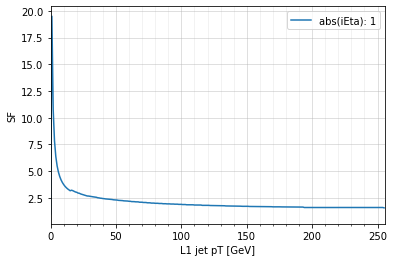

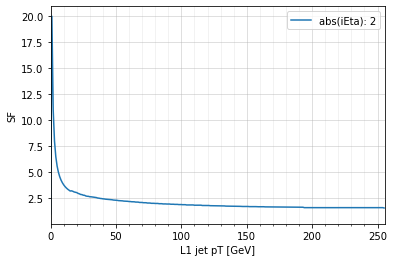

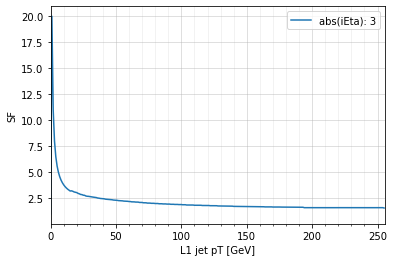

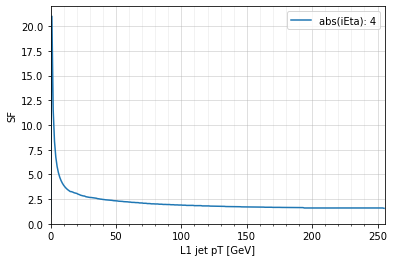

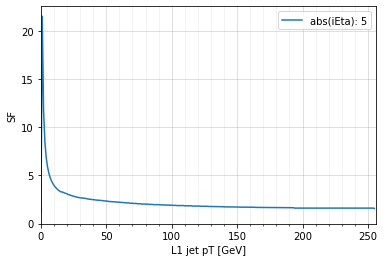

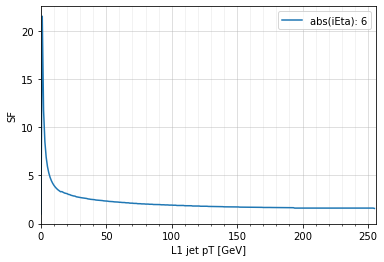

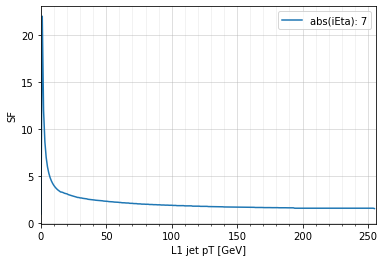

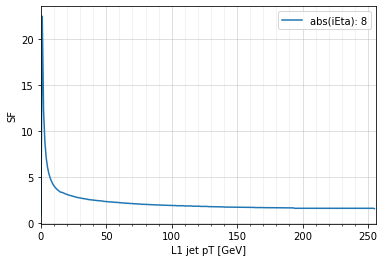

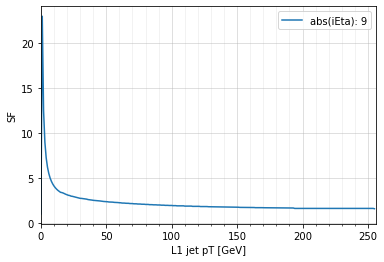

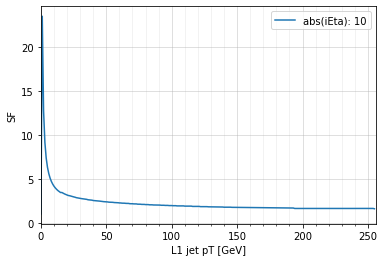

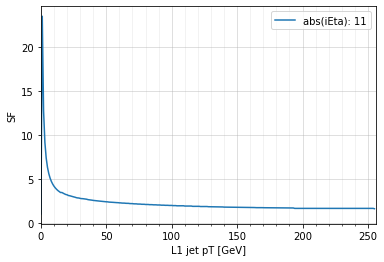

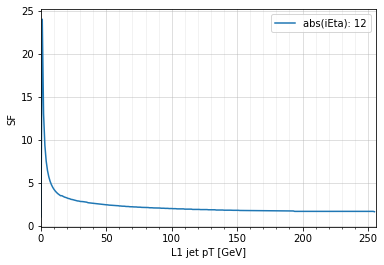

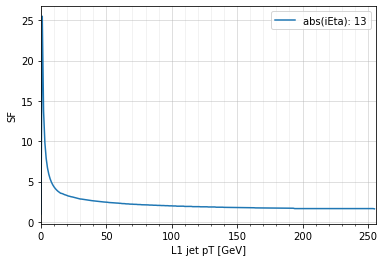

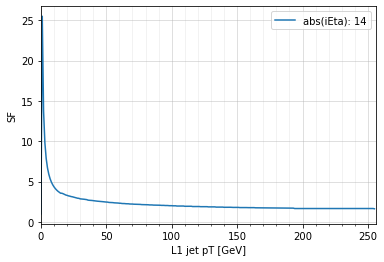

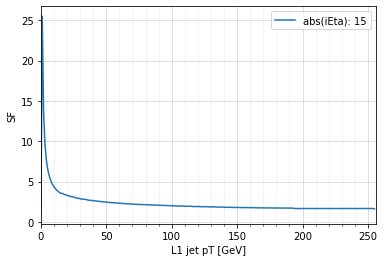

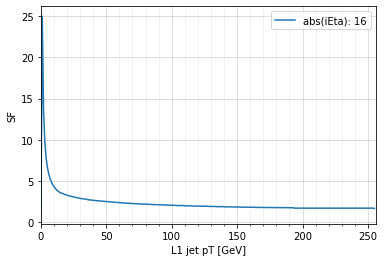

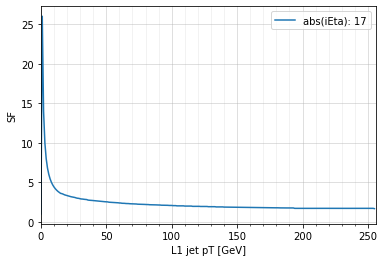

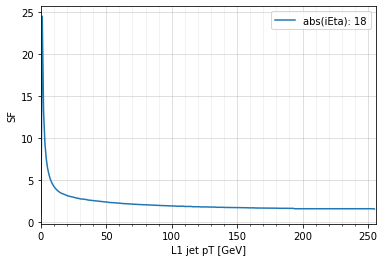

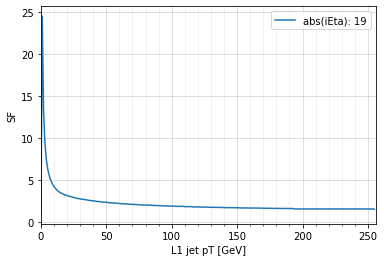

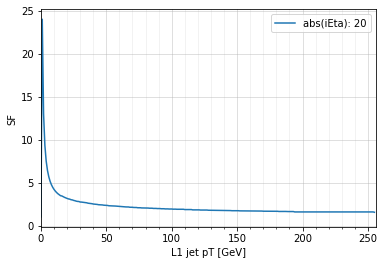

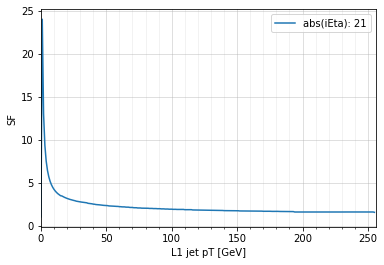

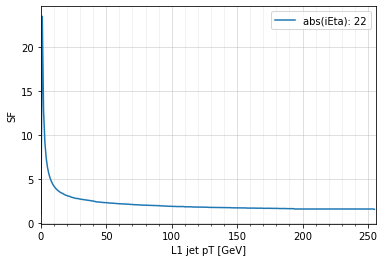

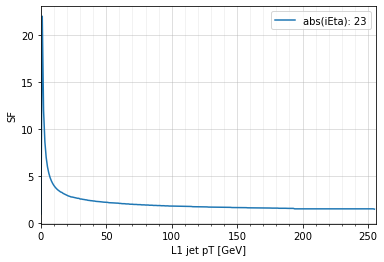

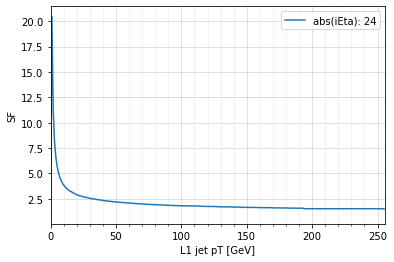

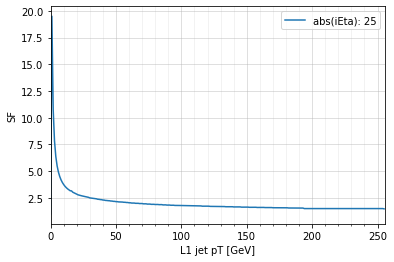

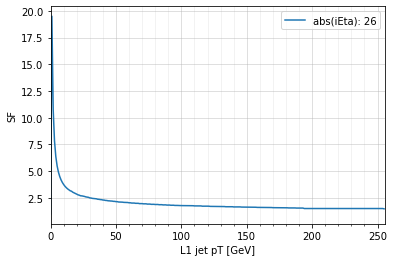

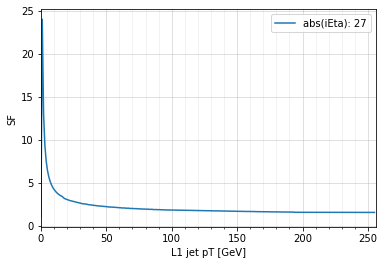

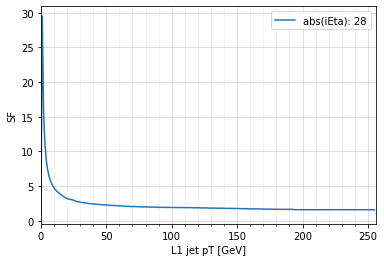

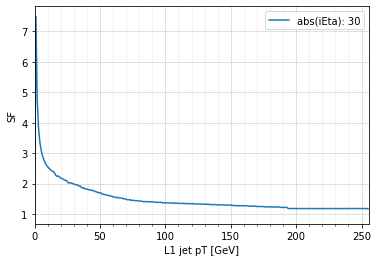

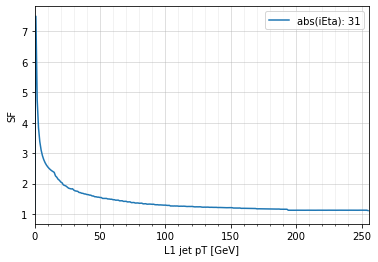

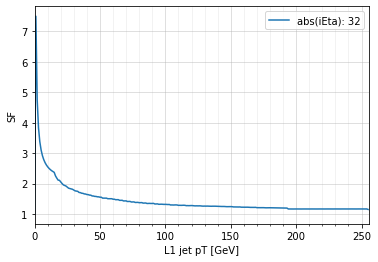

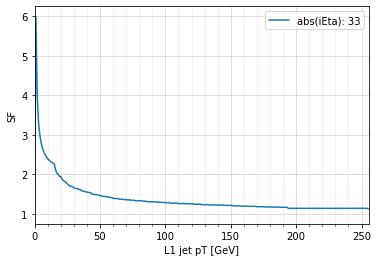

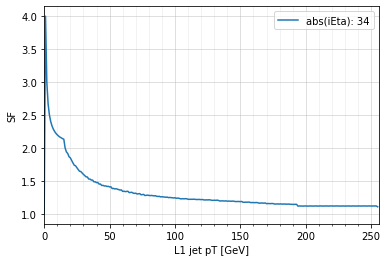

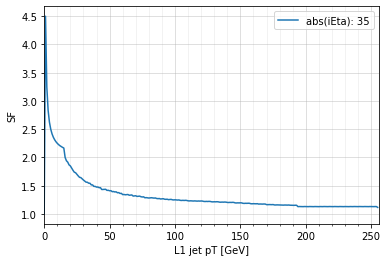

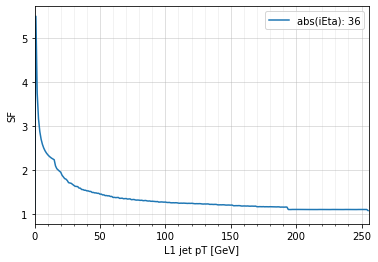

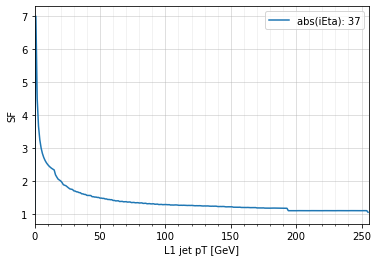

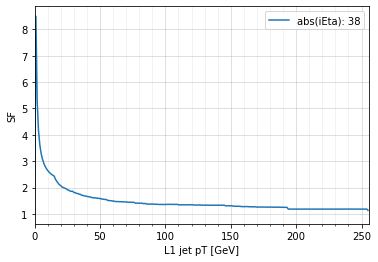

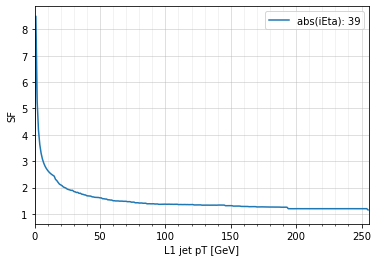

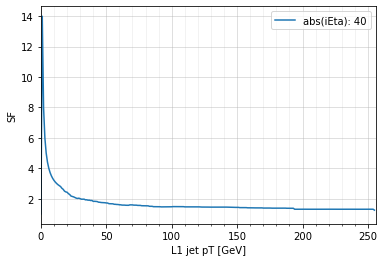

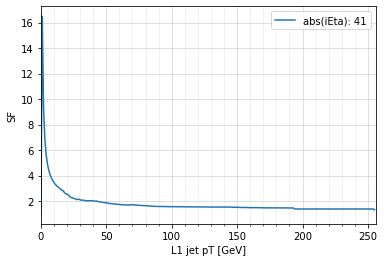

In [4]:
# plot SFs vs pT in each eta bin
#print(f"{lut_eta.data_dict.values() = }")
#print(f"{lut_pt.data_dict.items() = }")
for etaBin in set( lut_eta.data_dict.values() ):

    fig, ax = plt.subplots()

    # Collect iEtas sharing same etaBin in eta-compressed LUT
    iEta_Bins_compressed = []
    for  iEta in ETA_Bins:
        mpEta = map_CaloIEta_to_CaloTool_mpEta[ int(iEta) ]
        if lut_eta.data_dict[ mpEta ] == etaBin:
            iEta_Bins_compressed.append( int(iEta) )

    #print(f"{etaBin = }, {iEta_Bins_compressed = }")

    SFs_dict = {}
    for pt, ptBin in lut_pt.data_dict.items():
        ptCorr = calibrateJet(pt, iEta_Bins_compressed[0])
        SFs_dict[pt] = ptCorr / pt if pt > 0 else 1

    sIEtaRange = '[%d, %d]'%(iEta_Bins_compressed[0], iEta_Bins_compressed[-1]) if len(iEta_Bins_compressed) > 1 else iEta_Bins_compressed[0]
    ax.plot(SFs_dict.keys(), SFs_dict.values(), label='abs(iEta): %s' % (sIEtaRange))

    ax.set_xlabel('L1 jet pT [GeV]')
    ax.set_ylabel('SF')
    #ax.set_title("Simple Plot")  # Add a title to the axes.
    ax.legend()  # Add a legend.

    ax.set_xlim(0, 256)
    ax.set_xticks(np.arange(0,256, 50))
    ax.set_xticks(np.arange(0,256, 10), minor=True)

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)



In [5]:
if l1Jet_ChunkyDonut:
    data_all[sL1JetEt] = data_all['L1Jet9x9_RawEt'] - data_all['L1Jet9x9_PUEt_ChunkyDonut']
else:
    # data_all[sL1JetEt] = data_all['L1Jet9x9_RawEt'] - (data_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )
    data_all[sL1JetEt] = data_all['L1JetDefault_RawEt'] - data_all['L1JetDefault_PUEt_PhiRing']

In [6]:
sL1JetEt_calib = '%s_calib' % (sL1JetEt)
data_copy1     = data_all[[sL1JetTowerIEtaAbs, sL1JetEt, sRefJetEt]].copy()


data_copy1[sL1JetEt_calib] = data_copy1.apply(lambda row: calibrateJet(row[sL1JetEt], row[sL1JetTowerIEtaAbs]), axis=1)
if printLevel >= 10:
    print("data_copy1: {}".format(data_copy1))

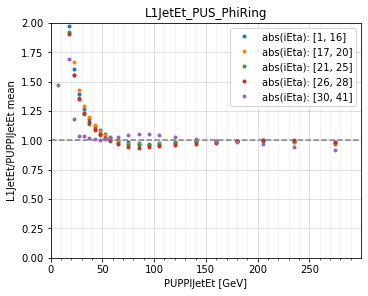

In [7]:
# L1T respones vs Pt: After JEC with  calibrateJet_wManipulate 
sOutDir_toUse = '%s/AfterJEC' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
for iEtaBinName, iEtaRange in IETA_CAT.items():
    #if iEtaBinName != 'HBEF': continue
    if iEtaBinName == 'HBEF': continue
    iEtaBin_first = iEtaRange[0]
    iEtaBin_last  = iEtaRange[1]
    
    L1JetPtResponse_vs_pt_dict = []
    L1JetPtResponseRMS_vs_pt_dict = []
    for iPtBin in range(0, len(pTBinEdges_forResolutionPlot)-1):
        pT_low  = pTBinEdges_forResolutionPlot[iPtBin]
        pT_high = pTBinEdges_forResolutionPlot[iPtBin+1]
        #print(f"{iPtBin = }, {pT_low = }, {pT_high = }")

        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) & 
            (data_copy1[sRefJetEt]  >= pT_low) & 
            (data_copy1[sRefJetEt]  <  pT_high)
            ) ]
        res_ = data_copy1_iEtaBin[sL1JetEt_calib] / data_copy1_iEtaBin[sRefJetEt]
        L1JetPtResponse_vs_pt_dict.append( np.mean(res_) )
        L1JetPtResponseRMS_vs_pt_dict.append( np.std(res_) )
    
    axs.errorbar(
        pTBinCenters_forResolutionPlot,
        L1JetPtResponse_vs_pt_dict,
        #yerr = L1JetPtResponseRMS_vs_pt_dict,
        label='abs(iEta): [%d, %d]'%(iEtaBin_first, iEtaBin_last),
        marker = '.',
        ls='none'
    )
    

axs.set_xlabel('PUPPIJetEt [GeV]')
axs.set_ylabel('L1JetEt/PUPPIJetEt mean')
axs.set_title('%s' % (sL1JetEt))
axs.set_xlim(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1])
axs.set_ylim(0, 2)
axs.hlines(1, pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], color='grey', ls='--')
axs.legend()

axs.set_xticks(np.arange(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], 50))
axs.set_xticks(np.arange(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], 10), minor=True)

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)
    
fig.savefig('%s/L1JetResponse_vs_Pt_%s.pdf' % (sOutDir_toUse, sL1JetEt))


In [ ]:
# L1T respones vs Pt: After JEC with  calibrateJet_wManipulate 
sOutDir_toUse = '%s/AfterJEC' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
for iEtaBinName, iEtaRange in IETA_CAT.items():
    #if iEtaBinName != 'HBEF': continue
    if iEtaBinName == 'HBEF': continue
    iEtaBin_first = iEtaRange[0]
    iEtaBin_last  = iEtaRange[1]
    
    L1JetPtResponse_vs_pt_dict = []
    L1JetPtResponseRMS_vs_pt_dict = []
    for iPtBin in range(0, len(pTBinEdges_forResolutionPlot)-1):
        pT_low  = pTBinEdges_forResolutionPlot[iPtBin]
        pT_high = pTBinEdges_forResolutionPlot[iPtBin+1]
        #print(f"{iPtBin = }, {pT_low = }, {pT_high = }")

        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) & 
            (data_copy1[sL1JetEt_calib]  >= pT_low) & 
            (data_copy1[sL1JetEt_calib]  <  pT_high)
            ) ]
        res_ = data_copy1_iEtaBin[sL1JetEt_calib] / data_copy1_iEtaBin[sRefJetEt]
        L1JetPtResponse_vs_pt_dict.append( np.mean(res_) )
        L1JetPtResponseRMS_vs_pt_dict.append( np.std(res_) )
    
    axs.errorbar(
        pTBinCenters_forResolutionPlot,
        L1JetPtResponse_vs_pt_dict,
        #yerr = L1JetPtResponseRMS_vs_pt_dict,
        label='abs(iEta): [%d, %d]'%(iEtaBin_first, iEtaBin_last),
        marker = '.',
        ls='none'
    )
    

axs.set_xlabel('L1JetEt [GeV]')
axs.set_ylabel('L1JetEt/PUPPIJetEt mean')
axs.set_title('%s' % (sL1JetEt))
axs.set_xlim(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1])
axs.set_ylim(0, 2)
axs.hlines(1, pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], color='grey', ls='--')
axs.legend()

axs.set_xticks(np.arange(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], 50))
axs.set_xticks(np.arange(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], 10), minor=True)

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)
    
fig.savefig('%s/L1JetResponse_vs_L1Pt_%s.pdf' % (sOutDir_toUse, sL1JetEt))


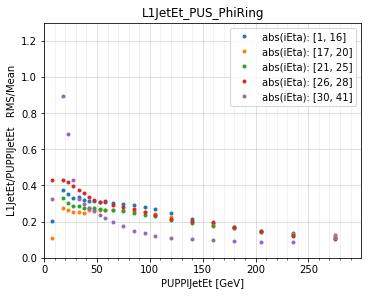

In [9]:
# L1T resolution vs Pt: After JEC with  calibrateJet_wManipulate 
sOutDir_toUse = '%s/AfterJEC' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
for iEtaBinName, iEtaRange in IETA_CAT.items():
    #if iEtaBinName != 'HBEF': continue
    if iEtaBinName == 'HBEF': continue
    iEtaBin_first = iEtaRange[0]
    iEtaBin_last  = iEtaRange[1]
    
    L1JetPtResponse_vs_pt_dict = []
    L1JetPtResponseRMS_vs_pt_dict = []
    L1JetPtResponseRMSByMean_vs_pt_dict = []
    for iPtBin in range(0, len(pTBinEdges_forResolutionPlot)-1):
        pT_low  = pTBinEdges_forResolutionPlot[iPtBin]
        pT_high = pTBinEdges_forResolutionPlot[iPtBin+1]
        #print(f"{iPtBin = }, {pT_low = }, {pT_high = }")

        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) & 
            (data_copy1[sRefJetEt]  >= pT_low) & 
            (data_copy1[sRefJetEt]  <  pT_high)
            ) ]
        res_ = data_copy1_iEtaBin[sL1JetEt_calib] / data_copy1_iEtaBin[sRefJetEt]
        L1JetPtResponse_vs_pt_dict.append( np.mean(res_) )
        L1JetPtResponseRMSByMean_vs_pt_dict.append( np.std(res_) / np.mean(res_) )
    
    axs.errorbar(
        pTBinCenters_forResolutionPlot,
        L1JetPtResponseRMSByMean_vs_pt_dict,
        #yerr = L1JetPtResponseRMS_vs_pt_dict,
        label='abs(iEta): [%d, %d]'%(iEtaBin_first, iEtaBin_last),
        marker = '.',
        ls='none'
    )
    

axs.set_xlabel('PUPPIJetEt [GeV]')
axs.set_ylabel('L1JetEt/PUPPIJetEt   RMS/Mean')
axs.set_title('%s' % (sL1JetEt))
axs.set_xlim(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1])
axs.set_ylim(0, 1.3)
#axs.hlines(1, pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], color='grey', ls='--')
axs.legend()

axs.set_xticks(np.arange(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], 50))
axs.set_xticks(np.arange(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], 10), minor=True)

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)

fig.savefig('%s/L1JetResolution_vs_Pt_%s.pdf' % (sOutDir_toUse, sL1JetEt))

IETA_CAT2 = OrderedDict([('HBEF', [1, 41]), ('HB', [1, 16]), ('HE1', [17, 28]), ('HF', [30, 41])])


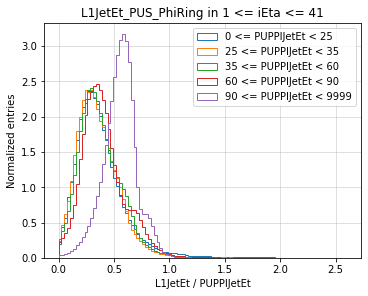

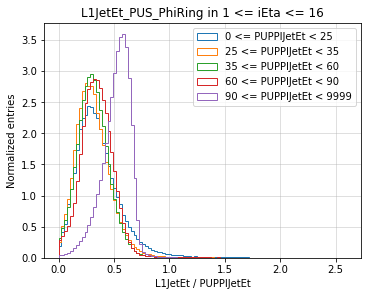

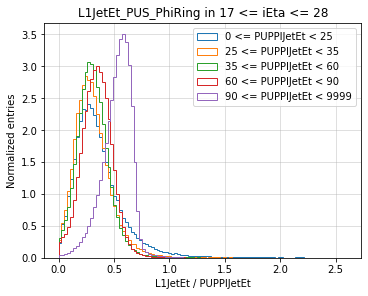

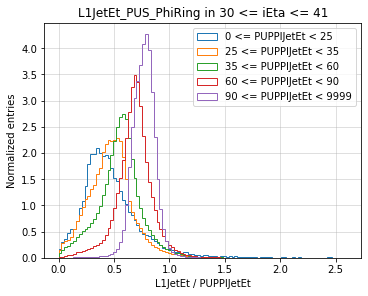

In [10]:
# Resolution plots before JEC
sOutDir_toUse = '%s/BeforeJEC/L1JetResponse_perEtaCat_PtCat' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )
print(f"{IETA_CAT2 = }")
#for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
for iEtaCatname, iEtaCatRange in IETA_CAT2.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = iEtaCatRange[0]
    iEtaBin_last  = iEtaCatRange[1]
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
            (data_copy1[sRefJetEt] >= pt_range[0]) & 
            (data_copy1[sRefJetEt] <  pt_range[2]) )]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= PUPPIJetEt < %d' % (pt_range[0], pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / PUPPIJetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.legend()

    axs.grid(which='minor', alpha=0.2)
    axs.grid(which='major', alpha=0.5)
        
    fig.savefig('%s/L1JetResponse_%s_ieta_%d_to_%d_inPtCat.pdf' % (sOutDir_toUse, sL1JetEt, iEtaBin_first, iEtaBin_last))

IETA_CAT2 = OrderedDict([('HBEF', [1, 41]), ('HB', [1, 16]), ('HE1', [17, 28]), ('HF', [30, 41])])


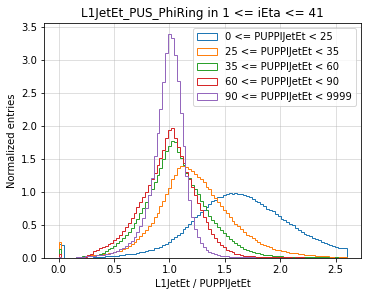

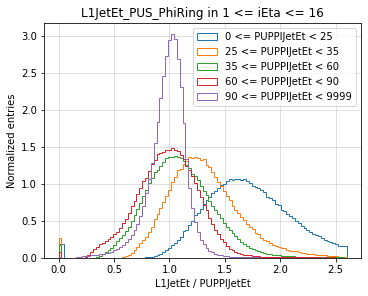

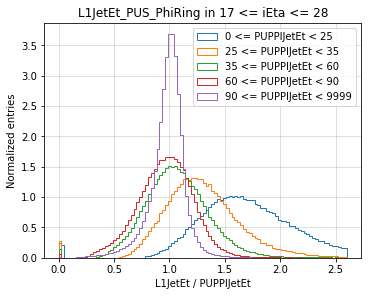

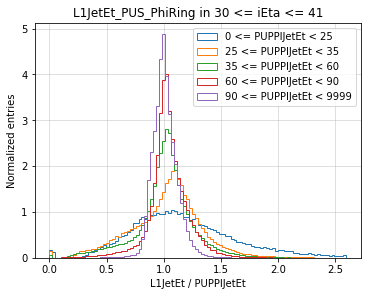

In [ ]:
# Resolution plots After JEC
sOutDir_toUse = '%s/AfterJEC/L1JetResponse_perEtaCat_PtCat' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )
print(f"{IETA_CAT2 = }")
#for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
for iEtaCatname, iEtaCatRange in IETA_CAT2.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = iEtaCatRange[0]
    iEtaBin_last  = iEtaCatRange[1]
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
            (data_copy1[sRefJetEt] >= pt_range[0]) & 
            (data_copy1[sRefJetEt] <  pt_range[2]) )]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= PUPPIJetEt < %d' % (pt_range[0], sRefJetEt, pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / PUPPIJetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.legend()

    axs.grid(which='minor', alpha=0.2)
    axs.grid(which='major', alpha=0.5)
            
    fig.savefig('%s/L1JetResponse_%s_ieta_%d_to_%d_inPtCat.pdf' % (sOutDir_toUse, sL1JetEt, iEtaBin_first, iEtaBin_last))

In [ ]:
# Resolution plots After JEC
sOutDir_toUse = '%s/AfterJEC/L1JetResponse_perEtaCat_L1PtCat' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )
print(f"{IETA_CAT2 = }")
#for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
for iEtaCatname, iEtaCatRange in IETA_CAT2.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = iEtaCatRange[0]
    iEtaBin_last  = iEtaCatRange[1]
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
            (data_copy1[sL1JetEt_calib] >= pt_range[0]) & 
            (data_copy1[sL1JetEt_calib] <  pt_range[2]) )]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= L1JetEt < %d' % (pt_range[0], pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / PUPPIJetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.legend()

    axs.grid(which='minor', alpha=0.2)
    axs.grid(which='major', alpha=0.5)
            
    fig.savefig('%s/L1JetResponse_%s_ieta_%d_to_%d_inPtCat.pdf' % (sOutDir_toUse, sL1JetEt, iEtaBin_first, iEtaBin_last))

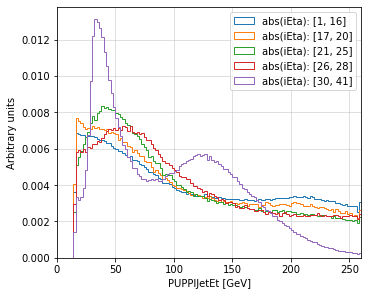

In [12]:
# GEN jet pT
sOutDir_toUse = '%s/AfterJEC' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
for iEtaBinName, iEtaRange in IETA_CAT.items():
    #if iEtaBinName != 'HBEF': continue
    if iEtaBinName == 'HBEF': continue
    iEtaBin_first = iEtaRange[0]
    iEtaBin_last  = iEtaRange[1]

    data_copy1_iEtaBin = data_copy1[ (
        (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
        (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) 
        ) ]
    axs.hist(
        data_copy1_iEtaBin[sRefJetEt],
        bins=int(260/2), range=(0, 260),
        label='abs(iEta): [%d, %d]'%(iEtaBin_first, iEtaBin_last),
        histtype='step',
        density=True
    )
    
    

axs.set_xlabel('PUPPIJetEt [GeV]')
axs.set_ylabel('Arbitrary units')
# axs.set_title('%s' % (sL1JetEt))
axs.set_xlim(0, 260)
#axs.set_ylim(0, 2)
#axs.hlines(1, pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], color='grey', ls='--')
axs.legend()

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)
    
fig.savefig('%s/GenJetPt.pdf' % (sOutDir_toUse))

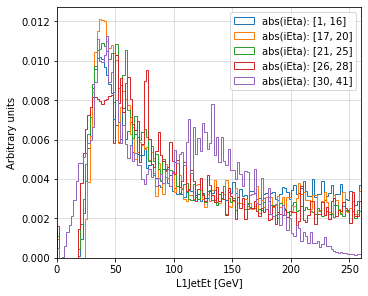

In [13]:
# L1T jet pT: After JEC with  calibrateJet_wManipulate 
sOutDir_toUse = '%s/AfterJEC' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
for iEtaBinName, iEtaRange in IETA_CAT.items():
    #if iEtaBinName != 'HBEF': continue
    if iEtaBinName == 'HBEF': continue
    iEtaBin_first = iEtaRange[0]
    iEtaBin_last  = iEtaRange[1]

    data_copy1_iEtaBin = data_copy1[ (
        (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
        (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) 
        ) ]
    axs.hist(
        data_copy1_iEtaBin[sL1JetEt_calib],
        bins=int(260/2), range=(0, 260),
        label='abs(iEta): [%d, %d]'%(iEtaBin_first, iEtaBin_last),
        histtype='step',
        density=True
    )
    
    

axs.set_xlabel('L1JetEt [GeV]')
axs.set_ylabel('Arbitrary units')
# axs.set_title('%s' % (sL1JetEt))
axs.set_xlim(0, 260)
#axs.set_ylim(0, 2)
#axs.hlines(1, pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], color='grey', ls='--')
axs.legend()

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)
    
fig.savefig('%s/L1JetPt_%s.pdf' % (sOutDir_toUse, sL1JetEt))